# DDPLKO Moduł 10 - praca domowa - Binary classification

To dziesiąta praca domowa w Programie szkoleniowym Klasyfikacja obrazu od Deep Drive PL

Twoim zadaniem w tym module będzie:
- [ ] Wybór 2 klas ze zbioru Open Images (https://storage.googleapis.com/openimages/web/index.html)
- [ ] Wykonanie dwóch treningów (może być własny model, lepiej transfer learning):
  - [ ] Bez ważonego lossu
  - [ ] z ważonym lossem
- [ ] UWAGA - w obu treningach monitoruj balanced accuracy!
- [ ] Udostępnij po 1 przykładowym zdjęciu z wybranych klas oraz wykres z porównaniem wyników validation balanced accuracy na Discordzie `#klasyfikacja-wyniki`

>Aby pobrać zdjęcia dla 2 klas możesz skorzystać za załączonych notebooków

W przypadku problemów z wielkością tego zbioru:
- możesz pracować na zmniejszonej rozdzielczości np. 32x32px
- możesz zmniejszyć liczbę próbek, ale zachowując ich stosunek (nie wyrównuj liczebności, by móc skorzystać z balanced accuracy)

Extra - dodatkowo możesz:
- wytrenować modele różnej wielkości np. EffNetB0 i EffNetB2 czy R18, R50, R101
- narysować krzywe ROC i PR z porównaniem modeli

In [1]:
import pandas as pd
import numpy as np
import urllib.request
import pathlib

from sklearn.utils import class_weight

from sklearn.metrics import balanced_accuracy_score


import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential

In [2]:
pathlib.Path("./openimages").mkdir(parents=True, exist_ok=True)

In [ ]:
train_classifications = 'https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-human-imagelabels.csv'
val_classifications = 'https://storage.googleapis.com/openimages/v5/validation-annotations-human-imagelabels.csv'
class_names = 'https://storage.googleapis.com/openimages/v6/oidv6-class-descriptions.csv'

urllib.request.urlretrieve(train_classifications, './openimages/train_classifications.csv')
urllib.request.urlretrieve(val_classifications, './openimages/val_classifications.csv')
urllib.request.urlretrieve(class_names, './openimages/class_names.csv');

In [ ]:
df_train = pd.read_csv('./openimages/train_classifications.csv')
df_val = pd.read_csv('./openimages/val_classifications.csv')
df_classes = pd.read_csv('./openimages/class_names.csv')

In [ ]:
', '.join(list(df_classes.DisplayName))

In [ ]:
df_train = pd.merge(df_train, df_classes, on='LabelName', how='left')
df_val = pd.merge(df_val, df_classes, on='LabelName', how='left')

# 2 classes from OpenImages

In [ ]:
# japoński naleśnik i zwykły naleśnik
chosen_classes = ["Okonomiyaki", "Pancake"]

In [ ]:
df_train = df_train[(df_train['DisplayName'] == chosen_classes[0]) | (df_train['DisplayName'] == chosen_classes[1])].reset_index(drop=True)
df_val = df_val[(df_val['DisplayName'] == chosen_classes[0]) | (df_val['DisplayName'] == chosen_classes[1])].reset_index(drop=True)

In [ ]:
df_train = df_train[df_train['Confidence'] == 1].reset_index(drop=True)
df_val = df_val[df_val['Confidence'] == 1].reset_index(drop=True)

In [ ]:
df_train.drop_duplicates(subset=['ImageID'], keep=False, inplace=True, ignore_index=True)
df_val.drop_duplicates(subset=['ImageID'], keep=False, inplace=True, ignore_index=True)

In [ ]:
df_train['text_file'] = 'train/' + df_train['ImageID']
df_val['text_file'] = 'validation/' + df_val['ImageID']

In [ ]:
for i, label in enumerate(chosen_classes):
    with open('./openimages/download_train_' + str(i+1) + '.txt', 'a') as f:
        f.write(df_train[df_train['DisplayName'] == label].to_string(columns=['text_file'], header=False, index=False))
    
    with open('./openimages/download_val_' + str(i+1) + '.txt', 'a') as f:
        f.write(df_val[df_val['DisplayName'] == label].to_string(columns=['text_file'], header=False, index=False))

In [ ]:
url = 'https://raw.githubusercontent.com/openimages/dataset/master/downloader.py'
urllib.request.urlretrieve(url, './openimages/downloader.py')

In [ ]:
!python ./openimages/downloader.py ./openimages/download_train_1.txt --download_folder=./openimages/train/class_1/

In [ ]:
!python ./openimages/downloader.py ./openimages/download_train_2.txt --download_folder=./openimages/train/class_2/

In [ ]:
!python ./openimages/downloader.py ./openimages/download_val_1.txt --download_folder=./openimages/validation/class_1/

In [ ]:
!python ./openimages/downloader.py ./openimages/download_val_2.txt --download_folder=./openimages/validation/class_2/

In [ ]:
df_train.shape

## Przygotowanie datasetu z dysku lokalnego

In [3]:
dir_train = './openimages/train'
dir_val = './openimages/validation'

In [4]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 395 files belonging to 2 classes.


In [5]:
ds_train

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [6]:
ds_val = tf.keras.utils.image_dataset_from_directory(
    dir_val, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(256,
    256), shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 56 files belonging to 2 classes.


In [7]:
# usuwam None 
ds_train = ds_train.unbatch()
ds_val = ds_val.unbatch()

In [8]:
# sprawdzam
ds_train

<_UnbatchDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.int32)>

In [9]:
X_train = list(map (lambda x: x[0], ds_train))
X_train = np.asarray(X_train)
X_train.shape

(395, 256, 256, 3)

In [10]:
X_val = list(map (lambda x: x[0], ds_val))
X_val = np.asarray(X_val)
X_val.shape

(56, 256, 256, 3)

In [11]:
y_train = ds_train.map(lambda image, label: (image, label))
y_train = list(map (lambda x: [x[1]], y_train))
y_train = np.asarray(y_train)
y_train.shape

(395, 1)

In [12]:
y_val = ds_val.map(lambda image, label: (image, label))
y_val = list(map (lambda x: [x[1]], y_val))
y_val = np.asarray(y_val)
y_val.shape

(56, 1)

# Model

In [13]:
epochs = 200
batch_size = 64

In [14]:
def getModel():
    model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(8,(5,5), padding='same', activation='relu', input_shape=(256, 256, 3)),
                tf.keras.layers.AveragePooling2D(2,2),
                tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
                tf.keras.layers.AveragePooling2D(2,2),
                tf.keras.layers.Conv2D(128,(3,3), padding='same', activation='relu'),
                tf.keras.layers.AveragePooling2D(2,2),
                tf.keras.layers.Conv2D(512,(1,1), padding='same', activation='relu'),
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(1, activation='sigmoid')])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.BinaryAccuracy()]) #'binary_accuracy'
    return model

In [15]:
model = getModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       608       
_________________________________________________________________
average_pooling2d (AveragePo (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      2336      
_________________________________________________________________
average_pooling2d_1 (Average (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       36992     
_________________________________________________________________
average_pooling2d_2 (Average (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 512)       6

# Training - no class weights

In [16]:
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val,y_val))

Epoch 1/200
7/7 [==============================] - 7s 971ms/step - loss: 3.8389 - binary_accuracy: 0.8025 - val_loss: 2.6041 - val_binary_accuracy: 0.9107
Epoch 2/200
7/7 [==============================] - 7s 946ms/step - loss: 1.0041 - binary_accuracy: 0.9013 - val_loss: 0.4073 - val_binary_accuracy: 0.9107
Epoch 3/200
7/7 [==============================] - 7s 935ms/step - loss: 0.3474 - binary_accuracy: 0.9291 - val_loss: 0.5634 - val_binary_accuracy: 0.9107
Epoch 4/200
7/7 [==============================] - 7s 956ms/step - loss: 0.3494 - binary_accuracy: 0.9291 - val_loss: 0.3427 - val_binary_accuracy: 0.9107
Epoch 5/200
7/7 [==============================] - 7s 952ms/step - loss: 0.2843 - binary_accuracy: 0.9291 - val_loss: 0.3482 - val_binary_accuracy: 0.9107
Epoch 6/200
7/7 [==============================] - 7s 958ms/step - loss: 0.2864 - binary_accuracy: 0.9291 - val_loss: 0.3550 - val_binary_accuracy: 0.9107
Epoch 7/200
7/7 [==============================] - 7s 950ms/step - los

7/7 [==============================] - 7s 940ms/step - loss: 0.1920 - binary_accuracy: 0.9316 - val_loss: 0.7967 - val_binary_accuracy: 0.9107
Epoch 106/200
7/7 [==============================] - 7s 950ms/step - loss: 0.1860 - binary_accuracy: 0.9392 - val_loss: 0.4963 - val_binary_accuracy: 0.9107
Epoch 107/200
7/7 [==============================] - 7s 948ms/step - loss: 0.2031 - binary_accuracy: 0.9342 - val_loss: 0.5568 - val_binary_accuracy: 0.8929
Epoch 108/200
7/7 [==============================] - 7s 937ms/step - loss: 0.1917 - binary_accuracy: 0.9342 - val_loss: 0.9049 - val_binary_accuracy: 0.9107
Epoch 109/200
7/7 [==============================] - 7s 955ms/step - loss: 0.1963 - binary_accuracy: 0.9342 - val_loss: 0.5395 - val_binary_accuracy: 0.8750
Epoch 110/200
7/7 [==============================] - 7s 950ms/step - loss: 0.1905 - binary_accuracy: 0.9342 - val_loss: 0.6677 - val_binary_accuracy: 0.9107
Epoch 111/200
7/7 [==============================] - 7s 943ms/step - los

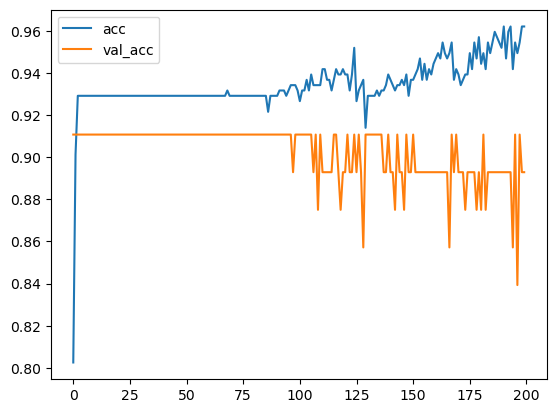

In [17]:
plt.plot(history.history['binary_accuracy'], label='acc')
plt.plot(history.history['val_binary_accuracy'], label='val_acc')
plt.legend()
plt.show();

In [18]:
del model

# Training - weighted loss

In [19]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  np.squeeze(y_train))
class_weights

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional argum

array([7.05357143, 0.53814714])

In [20]:
class_weights = dict(enumerate(class_weights))
class_weights

{0: 7.053571428571429, 1: 0.5381471389645777}

In [21]:
model = getModel()
history_weighted = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val,y_val),
                    class_weight=class_weights)

Epoch 1/200
7/7 [==============================] - 7s 955ms/step - loss: 1.9416 - binary_accuracy: 0.6608 - val_loss: 0.9364 - val_binary_accuracy: 0.1786
Epoch 2/200
7/7 [==============================] - 7s 924ms/step - loss: 0.9213 - binary_accuracy: 0.0987 - val_loss: 0.8496 - val_binary_accuracy: 0.1071
Epoch 3/200
7/7 [==============================] - 7s 943ms/step - loss: 0.6848 - binary_accuracy: 0.5696 - val_loss: 0.6175 - val_binary_accuracy: 0.9107
Epoch 4/200
7/7 [==============================] - 7s 937ms/step - loss: 0.6964 - binary_accuracy: 0.9291 - val_loss: 0.6482 - val_binary_accuracy: 0.9107
Epoch 5/200
7/7 [==============================] - 7s 926ms/step - loss: 0.6908 - binary_accuracy: 0.9291 - val_loss: 0.6610 - val_binary_accuracy: 0.9107
Epoch 6/200
7/7 [==============================] - 7s 942ms/step - loss: 0.6898 - binary_accuracy: 0.9291 - val_loss: 0.6695 - val_binary_accuracy: 0.9107
Epoch 7/200
7/7 [==============================] - 7s 939ms/step - los

7/7 [==============================] - 7s 924ms/step - loss: 0.6262 - binary_accuracy: 0.5899 - val_loss: 0.6407 - val_binary_accuracy: 0.5357
Epoch 106/200
7/7 [==============================] - 7s 935ms/step - loss: 0.6263 - binary_accuracy: 0.5646 - val_loss: 0.7163 - val_binary_accuracy: 0.4643
Epoch 107/200
7/7 [==============================] - 7s 940ms/step - loss: 0.6250 - binary_accuracy: 0.4506 - val_loss: 0.6333 - val_binary_accuracy: 0.6071
Epoch 108/200
7/7 [==============================] - 7s 926ms/step - loss: 0.6489 - binary_accuracy: 0.6557 - val_loss: 0.6714 - val_binary_accuracy: 0.5179
Epoch 109/200
7/7 [==============================] - 7s 937ms/step - loss: 0.6316 - binary_accuracy: 0.6025 - val_loss: 0.6561 - val_binary_accuracy: 0.5179
Epoch 110/200
7/7 [==============================] - 7s 940ms/step - loss: 0.6289 - binary_accuracy: 0.6911 - val_loss: 0.6860 - val_binary_accuracy: 0.4821
Epoch 111/200
7/7 [==============================] - 7s 926ms/step - los

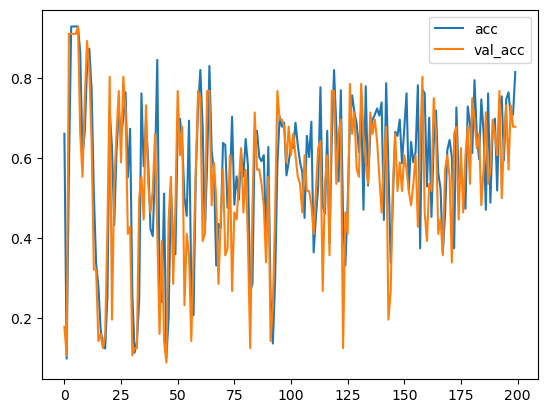

In [22]:
plt.plot(history_weighted.history['binary_accuracy'], label='acc')
plt.plot(history_weighted.history['val_binary_accuracy'], label='val_acc')
plt.legend()
plt.show();

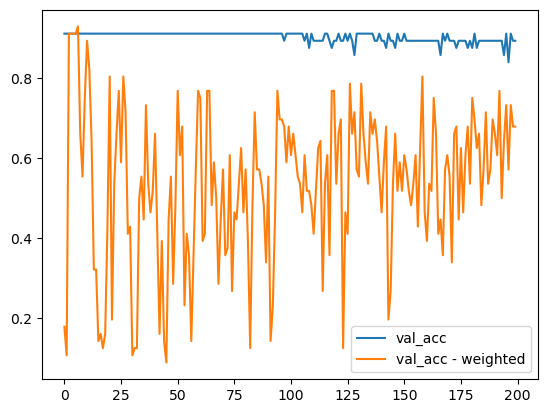

In [23]:
plt.plot(history.history['val_binary_accuracy'], label='val_acc')
plt.plot(history_weighted.history['val_binary_accuracy'], label='val_acc - weighted')
plt.legend()
plt.show();

In [24]:
del model

# Balanced accuracy - without vs with weighted loss

In [25]:
def balanced_accuracy(y_true, y_pred, sample_weight=None):
    y_true = y_true.numpy().astype(int) # compile model with run_eagerly=True
    y_pred = (y_pred.numpy()>0.5).astype(int)
    return balanced_accuracy_score(y_true, y_pred)

In [26]:
def getModel():
    model = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(8,(3,3), padding='same', activation='relu',input_shape=(256, 256, 3)),
                tf.keras.layers.AveragePooling2D(2,2),
                tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
                tf.keras.layers.AveragePooling2D(2,2),
                tf.keras.layers.Conv2D(128,(3,3), padding='same', activation='relu'),
                tf.keras.layers.AveragePooling2D(2,2),
                tf.keras.layers.Conv2D(512,(3,3), padding='same', activation='relu'),
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Dense(1, activation='sigmoid')])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                  loss='binary_crossentropy',
                  metrics=[balanced_accuracy, 'accuracy', 'binary_accuracy'],
                  run_eagerly=True)   # Error: AttributeError: 'Tensor' object has no attribute 'numpy'
    return model

In [27]:
model = getModel()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
average_pooling2d_6 (Average (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      2336      
_________________________________________________________________
average_pooling2d_7 (Average (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 128)       36992     
_________________________________________________________________
average_pooling2d_8 (Average (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 512)      

In [28]:
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val,y_val))

Epoch 1/200
7/7 [==============================] - 13s 2s/step - loss: 2.9631 - balanced_accuracy: 0.5153 - accuracy: 0.9063 - binary_accuracy: 0.9063 - val_loss: 0.7319 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 2/200
7/7 [==============================] - 11s 2s/step - loss: 0.8087 - balanced_accuracy: 0.5673 - accuracy: 0.7823 - binary_accuracy: 0.7823 - val_loss: 0.8104 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 3/200
7/7 [==============================] - 11s 2s/step - loss: 0.5382 - balanced_accuracy: 0.5000 - accuracy: 0.9291 - binary_accuracy: 0.9291 - val_loss: 0.4707 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 4/200
7/7 [==============================] - ETA: 0s - loss: 0.3376 - balanced_accuracy: 0.5499 - accuracy: 0.9089 - binary_accuracy: 0.9089

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.3376 - balanced_accuracy: 0.5499 - accuracy: 0.9089 - binary_accuracy: 0.9089 - val_loss: 0.3290 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 5/200
7/7 [==============================] - 11s 2s/step - loss: 0.3087 - balanced_accuracy: 0.5641 - accuracy: 0.9139 - binary_accuracy: 0.9139 - val_loss: 0.3891 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 6/200
7/7 [==============================] - 11s 2s/step - loss: 0.3123 - balanced_accuracy: 0.5714 - accuracy: 0.9291 - binary_accuracy: 0.9291 - val_loss: 0.3883 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 7/200
7/7 [==============================] - 11s 2s/step - loss: 0.2843 - balanced_accuracy: 0.5714 - accuracy: 0.9291 - binary_accuracy: 0.9291 - val_loss: 0.3407 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy:

7/7 [==============================] - 11s 2s/step - loss: 0.2256 - balanced_accuracy: 0.5286 - accuracy: 0.9342 - binary_accuracy: 0.9342 - val_loss: 0.3014 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 69/200
7/7 [==============================] - 11s 2s/step - loss: 0.2327 - balanced_accuracy: 0.5143 - accuracy: 0.9316 - binary_accuracy: 0.9316 - val_loss: 0.2909 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 70/200
7/7 [==============================] - 11s 2s/step - loss: 0.2139 - balanced_accuracy: 0.5102 - accuracy: 0.9316 - binary_accuracy: 0.9316 - val_loss: 0.3144 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 71/200
7/7 [==============================] - 11s 2s/step - loss: 0.2230 - balanced_accuracy: 0.5923 - accuracy: 0.9342 - binary_accuracy: 0.9342 - val_loss: 0.3375 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accura

7/7 [==============================] - 11s 2s/step - loss: 0.1822 - balanced_accuracy: 0.5440 - accuracy: 0.9316 - binary_accuracy: 0.9316 - val_loss: 0.3416 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 101/200
7/7 [==============================] - 11s 2s/step - loss: 0.1965 - balanced_accuracy: 0.5179 - accuracy: 0.9316 - binary_accuracy: 0.9316 - val_loss: 0.3758 - val_balanced_accuracy: 0.4804 - val_accuracy: 0.8750 - val_binary_accuracy: 0.8750
Epoch 102/200
7/7 [==============================] - 11s 2s/step - loss: 0.2260 - balanced_accuracy: 0.6119 - accuracy: 0.9418 - binary_accuracy: 0.9418 - val_loss: 0.3565 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 103/200
7/7 [==============================] - 11s 2s/step - loss: 0.2053 - balanced_accuracy: 0.5833 - accuracy: 0.9316 - binary_accuracy: 0.9316 - val_loss: 0.3146 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_acc

Epoch 132/200
7/7 [==============================] - 11s 2s/step - loss: 0.1418 - balanced_accuracy: 0.6216 - accuracy: 0.9468 - binary_accuracy: 0.9468 - val_loss: 0.4095 - val_balanced_accuracy: 0.4902 - val_accuracy: 0.8929 - val_binary_accuracy: 0.8929
Epoch 133/200
7/7 [==============================] - 11s 2s/step - loss: 0.1532 - balanced_accuracy: 0.6832 - accuracy: 0.9468 - binary_accuracy: 0.9468 - val_loss: 0.4037 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 134/200
7/7 [==============================] - 11s 2s/step - loss: 0.1360 - balanced_accuracy: 0.6762 - accuracy: 0.9494 - binary_accuracy: 0.9494 - val_loss: 0.4187 - val_balanced_accuracy: 0.4608 - val_accuracy: 0.8393 - val_binary_accuracy: 0.8393
Epoch 135/200
7/7 [==============================] - 11s 2s/step - loss: 0.1471 - balanced_accuracy: 0.7254 - accuracy: 0.9519 - binary_accuracy: 0.9519 - val_loss: 0.3944 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - 

Epoch 164/200
7/7 [==============================] - 11s 2s/step - loss: 0.1183 - balanced_accuracy: 0.7467 - accuracy: 0.9544 - binary_accuracy: 0.9544 - val_loss: 0.4310 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 165/200
7/7 [==============================] - 11s 2s/step - loss: 0.1219 - balanced_accuracy: 0.7187 - accuracy: 0.9418 - binary_accuracy: 0.9418 - val_loss: 0.4564 - val_balanced_accuracy: 0.4706 - val_accuracy: 0.8571 - val_binary_accuracy: 0.8571
Epoch 166/200
7/7 [==============================] - 11s 2s/step - loss: 0.1095 - balanced_accuracy: 0.7518 - accuracy: 0.9544 - binary_accuracy: 0.9544 - val_loss: 0.4630 - val_balanced_accuracy: 0.4804 - val_accuracy: 0.8750 - val_binary_accuracy: 0.8750
Epoch 167/200
7/7 [==============================] - 11s 2s/step - loss: 0.0990 - balanced_accuracy: 0.7912 - accuracy: 0.9620 - binary_accuracy: 0.9620 - val_loss: 0.4768 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - 

Epoch 196/200
7/7 [==============================] - 11s 2s/step - loss: 0.0952 - balanced_accuracy: 0.8904 - accuracy: 0.9772 - binary_accuracy: 0.9772 - val_loss: 0.6843 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 197/200
7/7 [==============================] - 11s 2s/step - loss: 0.1075 - balanced_accuracy: 0.6622 - accuracy: 0.9519 - binary_accuracy: 0.9519 - val_loss: 0.5394 - val_balanced_accuracy: 0.4608 - val_accuracy: 0.8393 - val_binary_accuracy: 0.8393
Epoch 198/200
7/7 [==============================] - 11s 2s/step - loss: 0.1158 - balanced_accuracy: 0.7958 - accuracy: 0.9570 - binary_accuracy: 0.9570 - val_loss: 0.5604 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 199/200
7/7 [==============================] - 11s 2s/step - loss: 0.1194 - balanced_accuracy: 0.6531 - accuracy: 0.9494 - binary_accuracy: 0.9494 - val_loss: 0.5308 - val_balanced_accuracy: 0.4608 - val_accuracy: 0.8393 - 

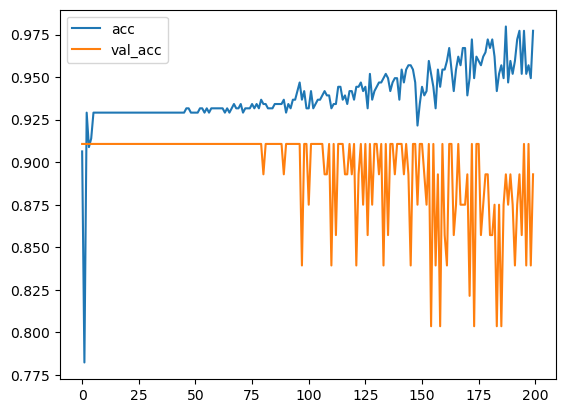

In [29]:
plt.plot(history.history['binary_accuracy'], label='acc')
plt.plot(history.history['val_binary_accuracy'], label='val_acc')
plt.legend()
plt.show();

In [30]:
history.history.keys()

dict_keys(['loss', 'balanced_accuracy', 'accuracy', 'binary_accuracy', 'val_loss', 'val_balanced_accuracy', 'val_accuracy', 'val_binary_accuracy'])

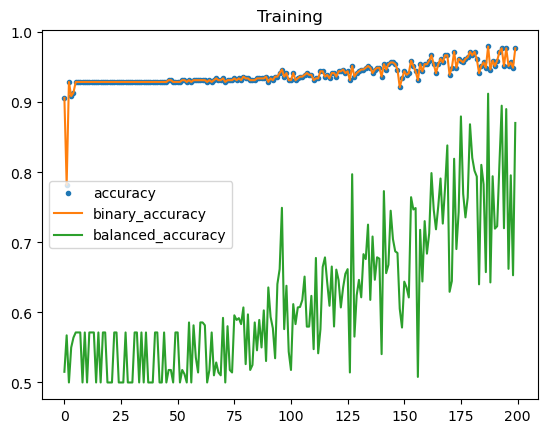

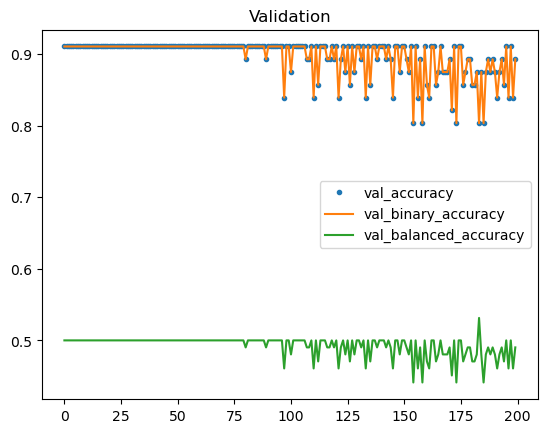

In [31]:
plt.plot(history.history['accuracy'], '.', label='accuracy')
plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['balanced_accuracy'], label='balanced_accuracy')
plt.legend();
plt.title('Training')
plt.show();

plt.figure()
plt.plot(history.history['val_accuracy'], '.', label='val_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.plot(history.history['val_balanced_accuracy'], label='val_balanced_accuracy')
plt.legend();
plt.title('Validation')
plt.show();

In [32]:
del model

## Weighted

In [33]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  np.squeeze(y_train))
class_weights

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional argum

array([7.05357143, 0.53814714])

In [34]:
class_weights = dict(enumerate(class_weights))
class_weights

{0: 7.053571428571429, 1: 0.5381471389645777}

In [35]:
model = getModel()
history_weighted = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val,y_val),
                    class_weight=class_weights)

Epoch 1/200
7/7 [==============================] - ETA: 0s - loss: 5.2465 - balanced_accuracy: 0.4441 - accuracy: 0.5291 - binary_accuracy: 0.5291

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 5.2465 - balanced_accuracy: 0.4441 - accuracy: 0.5291 - binary_accuracy: 0.5291 - val_loss: 1.6577 - val_balanced_accuracy: 0.5098 - val_accuracy: 0.1071 - val_binary_accuracy: 0.1071
Epoch 2/200
7/7 [==============================] - ETA: 0s - loss: 2.2479 - balanced_accuracy: 0.4354 - accuracy: 0.5089 - binary_accuracy: 0.5089

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 2.2479 - balanced_accuracy: 0.4354 - accuracy: 0.5089 - binary_accuracy: 0.5089 - val_loss: 1.9147 - val_balanced_accuracy: 0.5098 - val_accuracy: 0.1071 - val_binary_accuracy: 0.1071
Epoch 3/200
7/7 [==============================] - 11s 2s/step - loss: 1.1678 - balanced_accuracy: 0.5519 - accuracy: 0.4835 - binary_accuracy: 0.4835 - val_loss: 0.3649 - val_balanced_accuracy: 0.5000 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 4/200
7/7 [==============================] - ETA: 0s - loss: 1.1948 - balanced_accuracy: 0.5185 - accuracy: 0.4532 - binary_accuracy: 0.4532

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 1.1948 - balanced_accuracy: 0.5185 - accuracy: 0.4532 - binary_accuracy: 0.4532 - val_loss: 1.3112 - val_balanced_accuracy: 0.5098 - val_accuracy: 0.1071 - val_binary_accuracy: 0.1071
Epoch 5/200
7/7 [==============================] - ETA: 0s - loss: 0.9686 - balanced_accuracy: 0.5157 - accuracy: 0.5013 - binary_accuracy: 0.5013

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.9686 - balanced_accuracy: 0.5157 - accuracy: 0.5013 - binary_accuracy: 0.5013 - val_loss: 0.4836 - val_balanced_accuracy: 0.5804 - val_accuracy: 0.8929 - val_binary_accuracy: 0.8929
Epoch 6/200
7/7 [==============================] - 11s 2s/step - loss: 0.9281 - balanced_accuracy: 0.4965 - accuracy: 0.6810 - binary_accuracy: 0.6810 - val_loss: 1.0241 - val_balanced_accuracy: 0.5392 - val_accuracy: 0.1607 - val_binary_accuracy: 0.1607
Epoch 7/200
7/7 [==============================] - 11s 2s/step - loss: 0.7839 - balanced_accuracy: 0.4836 - accuracy: 0.3823 - binary_accuracy: 0.3823 - val_loss: 0.6852 - val_balanced_accuracy: 0.3667 - val_accuracy: 0.3393 - val_binary_accuracy: 0.3393
Epoch 8/200
7/7 [==============================] - 11s 2s/step - loss: 0.7053 - balanced_accuracy: 0.5782 - accuracy: 0.4228 - binary_accuracy: 0.4228 - val_loss: 0.7223 - val_balanced_accuracy: 0.4373 - val_accuracy: 0.3036 - val_binary_accuracy:

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.8173 - balanced_accuracy: 0.4566 - accuracy: 0.5570 - binary_accuracy: 0.5570 - val_loss: 0.7056 - val_balanced_accuracy: 0.4667 - val_accuracy: 0.3571 - val_binary_accuracy: 0.3571
Epoch 10/200
7/7 [==============================] - 11s 2s/step - loss: 0.6943 - balanced_accuracy: 0.5319 - accuracy: 0.5595 - binary_accuracy: 0.5595 - val_loss: 0.6981 - val_balanced_accuracy: 0.4863 - val_accuracy: 0.3929 - val_binary_accuracy: 0.3929
Epoch 11/200
7/7 [==============================] - ETA: 0s - loss: 0.6273 - balanced_accuracy: 0.6142 - accuracy: 0.5696 - binary_accuracy: 0.5696

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.6273 - balanced_accuracy: 0.6142 - accuracy: 0.5696 - binary_accuracy: 0.5696 - val_loss: 0.7114 - val_balanced_accuracy: 0.4667 - val_accuracy: 0.3571 - val_binary_accuracy: 0.3571
Epoch 12/200
7/7 [==============================] - ETA: 0s - loss: 0.7758 - balanced_accuracy: 0.4441 - accuracy: 0.4051 - binary_accuracy: 0.4051

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.7758 - balanced_accuracy: 0.4441 - accuracy: 0.4051 - binary_accuracy: 0.4051 - val_loss: 0.6751 - val_balanced_accuracy: 0.4961 - val_accuracy: 0.4107 - val_binary_accuracy: 0.4107
Epoch 13/200
7/7 [==============================] - ETA: 0s - loss: 0.6728 - balanced_accuracy: 0.5899 - accuracy: 0.6380 - binary_accuracy: 0.6380

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.6728 - balanced_accuracy: 0.5899 - accuracy: 0.6380 - binary_accuracy: 0.6380 - val_loss: 0.5416 - val_balanced_accuracy: 0.5804 - val_accuracy: 0.8929 - val_binary_accuracy: 0.8929
Epoch 14/200
7/7 [==============================] - 11s 2s/step - loss: 0.7172 - balanced_accuracy: 0.4869 - accuracy: 0.7519 - binary_accuracy: 0.7519 - val_loss: 0.8291 - val_balanced_accuracy: 0.5882 - val_accuracy: 0.2500 - val_binary_accuracy: 0.2500
Epoch 15/200
7/7 [==============================] - ETA: 0s - loss: 0.7184 - balanced_accuracy: 0.5350 - accuracy: 0.2633 - binary_accuracy: 0.2633

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.7184 - balanced_accuracy: 0.5350 - accuracy: 0.2633 - binary_accuracy: 0.2633 - val_loss: 0.7574 - val_balanced_accuracy: 0.6667 - val_accuracy: 0.3929 - val_binary_accuracy: 0.3929
Epoch 16/200
7/7 [==============================] - 11s 2s/step - loss: 0.6849 - balanced_accuracy: 0.6891 - accuracy: 0.6835 - binary_accuracy: 0.6835 - val_loss: 0.5788 - val_balanced_accuracy: 0.6314 - val_accuracy: 0.8214 - val_binary_accuracy: 0.8214
Epoch 17/200
7/7 [==============================] - ETA: 0s - loss: 0.6646 - balanced_accuracy: 0.6184 - accuracy: 0.6405 - binary_accuracy: 0.6405

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.6646 - balanced_accuracy: 0.6184 - accuracy: 0.6405 - binary_accuracy: 0.6405 - val_loss: 0.6791 - val_balanced_accuracy: 0.5451 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 18/200
5/7 [====================>.........] - ETA: 3s - loss: 0.6197 - balanced_accuracy: 0.6072 - accuracy: 0.4969 - binary_accuracy: 0.4969

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.6480 - balanced_accuracy: 0.5650 - accuracy: 0.5215 - binary_accuracy: 0.5215 - val_loss: 0.6380 - val_balanced_accuracy: 0.4941 - val_accuracy: 0.5714 - val_binary_accuracy: 0.5714
Epoch 19/200
7/7 [==============================] - ETA: 0s - loss: 0.6822 - balanced_accuracy: 0.4266 - accuracy: 0.4886 - binary_accuracy: 0.4886

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.6822 - balanced_accuracy: 0.4266 - accuracy: 0.4886 - binary_accuracy: 0.4886 - val_loss: 0.7116 - val_balanced_accuracy: 0.5667 - val_accuracy: 0.3750 - val_binary_accuracy: 0.3750
Epoch 20/200
7/7 [==============================] - 11s 2s/step - loss: 0.6837 - balanced_accuracy: 0.5289 - accuracy: 0.5924 - binary_accuracy: 0.5924 - val_loss: 0.6772 - val_balanced_accuracy: 0.4863 - val_accuracy: 0.3929 - val_binary_accuracy: 0.3929
Epoch 21/200
7/7 [==============================] - 11s 2s/step - loss: 0.6476 - balanced_accuracy: 0.5875 - accuracy: 0.3367 - binary_accuracy: 0.3367 - val_loss: 0.8144 - val_balanced_accuracy: 0.6078 - val_accuracy: 0.2857 - val_binary_accuracy: 0.2857
Epoch 22/200
7/7 [==============================] - 11s 2s/step - loss: 0.6249 - balanced_accuracy: 0.6238 - accuracy: 0.5544 - binary_accuracy: 0.5544 - val_loss: 0.6316 - val_balanced_accuracy: 0.5451 - val_accuracy: 0.5000 - val_binary_accura

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.6836 - balanced_accuracy: 0.5369 - accuracy: 0.4278 - binary_accuracy: 0.4278 - val_loss: 0.8828 - val_balanced_accuracy: 0.5490 - val_accuracy: 0.1786 - val_binary_accuracy: 0.1786
Epoch 28/200
7/7 [==============================] - 11s 2s/step - loss: 0.6352 - balanced_accuracy: 0.6008 - accuracy: 0.4405 - binary_accuracy: 0.4405 - val_loss: 0.5812 - val_balanced_accuracy: 0.5922 - val_accuracy: 0.7500 - val_binary_accuracy: 0.7500
Epoch 29/200
7/7 [==============================] - 11s 2s/step - loss: 0.6441 - balanced_accuracy: 0.6984 - accuracy: 0.7797 - binary_accuracy: 0.7797 - val_loss: 0.6560 - val_balanced_accuracy: 0.5647 - val_accuracy: 0.5357 - val_binary_accuracy: 0.5357
Epoch 30/200
7/7 [==============================] - 11s 2s/step - loss: 0.6263 - balanced_accuracy: 0.6241 - accuracy: 0.5089 - binary_accuracy: 0.5089 - val_loss: 0.7124 - val_balanced_accuracy: 0.6667 - val_accuracy: 0.3929 - val_binary_accura

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.6319 - balanced_accuracy: 0.5693 - accuracy: 0.4101 - binary_accuracy: 0.4101 - val_loss: 0.7106 - val_balanced_accuracy: 0.5667 - val_accuracy: 0.3750 - val_binary_accuracy: 0.3750
Epoch 32/200
7/7 [==============================] - 11s 2s/step - loss: 0.6188 - balanced_accuracy: 0.5941 - accuracy: 0.5696 - binary_accuracy: 0.5696 - val_loss: 0.7132 - val_balanced_accuracy: 0.4765 - val_accuracy: 0.3750 - val_binary_accuracy: 0.3750
Epoch 33/200
7/7 [==============================] - 11s 2s/step - loss: 0.5996 - balanced_accuracy: 0.6500 - accuracy: 0.4658 - binary_accuracy: 0.4658 - val_loss: 0.8482 - val_balanced_accuracy: 0.5765 - val_accuracy: 0.3929 - val_binary_accuracy: 0.3929
Epoch 34/200
7/7 [==============================] - 11s 2s/step - loss: 0.7059 - balanced_accuracy: 0.6305 - accuracy: 0.2835 - binary_accuracy: 0.2835 - val_loss: 0.7402 - val_balanced_accuracy: 0.6059 - val_accuracy: 0.4464 - val_binary_accura

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.6145 - balanced_accuracy: 0.6206 - accuracy: 0.4684 - binary_accuracy: 0.4684 - val_loss: 0.6430 - val_balanced_accuracy: 0.4745 - val_accuracy: 0.5357 - val_binary_accuracy: 0.5357
Epoch 38/200
7/7 [==============================] - 11s 2s/step - loss: 0.6271 - balanced_accuracy: 0.6021 - accuracy: 0.7722 - binary_accuracy: 0.7722 - val_loss: 0.6801 - val_balanced_accuracy: 0.4961 - val_accuracy: 0.4107 - val_binary_accuracy: 0.4107
Epoch 39/200
7/7 [==============================] - 11s 2s/step - loss: 0.6039 - balanced_accuracy: 0.6418 - accuracy: 0.3747 - binary_accuracy: 0.3747 - val_loss: 0.7833 - val_balanced_accuracy: 0.5471 - val_accuracy: 0.3393 - val_binary_accuracy: 0.3393
Epoch 40/200
7/7 [==============================] - ETA: 0s - loss: 0.6046 - balanced_accuracy: 0.6477 - accuracy: 0.4405 - binary_accuracy: 0.4405

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.6046 - balanced_accuracy: 0.6477 - accuracy: 0.4405 - binary_accuracy: 0.4405 - val_loss: 0.6495 - val_balanced_accuracy: 0.6157 - val_accuracy: 0.4643 - val_binary_accuracy: 0.4643
Epoch 41/200
7/7 [==============================] - 11s 2s/step - loss: 0.5671 - balanced_accuracy: 0.7250 - accuracy: 0.5747 - binary_accuracy: 0.5747 - val_loss: 0.6041 - val_balanced_accuracy: 0.4647 - val_accuracy: 0.5179 - val_binary_accuracy: 0.5179
Epoch 42/200
7/7 [==============================] - ETA: 0s - loss: 0.5732 - balanced_accuracy: 0.7023 - accuracy: 0.5342 - binary_accuracy: 0.5342

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5732 - balanced_accuracy: 0.7023 - accuracy: 0.5342 - binary_accuracy: 0.5342 - val_loss: 0.6812 - val_balanced_accuracy: 0.5059 - val_accuracy: 0.4286 - val_binary_accuracy: 0.4286
Epoch 43/200
7/7 [==============================] - 11s 2s/step - loss: 0.5666 - balanced_accuracy: 0.7766 - accuracy: 0.7190 - binary_accuracy: 0.7190 - val_loss: 0.5521 - val_balanced_accuracy: 0.5431 - val_accuracy: 0.6607 - val_binary_accuracy: 0.6607
Epoch 44/200
7/7 [==============================] - ETA: 0s - loss: 0.5532 - balanced_accuracy: 0.6995 - accuracy: 0.6684 - binary_accuracy: 0.6684

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5532 - balanced_accuracy: 0.6995 - accuracy: 0.6684 - binary_accuracy: 0.6684 - val_loss: 0.7161 - val_balanced_accuracy: 0.3961 - val_accuracy: 0.3929 - val_binary_accuracy: 0.3929
Epoch 45/200
7/7 [==============================] - 11s 2s/step - loss: 0.5297 - balanced_accuracy: 0.7686 - accuracy: 0.6582 - binary_accuracy: 0.6582 - val_loss: 0.5830 - val_balanced_accuracy: 0.5333 - val_accuracy: 0.6429 - val_binary_accuracy: 0.6429
Epoch 46/200
7/7 [==============================] - 11s 2s/step - loss: 0.5547 - balanced_accuracy: 0.7032 - accuracy: 0.5975 - binary_accuracy: 0.5975 - val_loss: 0.8276 - val_balanced_accuracy: 0.4667 - val_accuracy: 0.3571 - val_binary_accuracy: 0.3571
Epoch 47/200
7/7 [==============================] - ETA: 0s - loss: 0.5355 - balanced_accuracy: 0.6976 - accuracy: 0.5063 - binary_accuracy: 0.5063

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5355 - balanced_accuracy: 0.6976 - accuracy: 0.5063 - binary_accuracy: 0.5063 - val_loss: 0.5156 - val_balanced_accuracy: 0.5020 - val_accuracy: 0.7500 - val_binary_accuracy: 0.7500
Epoch 48/200
7/7 [==============================] - 11s 2s/step - loss: 0.5489 - balanced_accuracy: 0.7719 - accuracy: 0.7873 - binary_accuracy: 0.7873 - val_loss: 0.6381 - val_balanced_accuracy: 0.5039 - val_accuracy: 0.5893 - val_binary_accuracy: 0.5893
Epoch 49/200
1/7 [===>..........................] - ETA: 10s - loss: 0.2829 - balanced_accuracy: 0.6094 - accuracy: 0.6094 - binary_accuracy: 0.6094

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - ETA: 0s - loss: 0.5174 - balanced_accuracy: 0.6836 - accuracy: 0.6101 - binary_accuracy: 0.6101

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5174 - balanced_accuracy: 0.6836 - accuracy: 0.6101 - binary_accuracy: 0.6101 - val_loss: 0.6856 - val_balanced_accuracy: 0.4549 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 50/200
7/7 [==============================] - ETA: 0s - loss: 0.5362 - balanced_accuracy: 0.6227 - accuracy: 0.7165 - binary_accuracy: 0.7165

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5362 - balanced_accuracy: 0.6227 - accuracy: 0.7165 - binary_accuracy: 0.7165 - val_loss: 0.6236 - val_balanced_accuracy: 0.4843 - val_accuracy: 0.5536 - val_binary_accuracy: 0.5536
Epoch 51/200
7/7 [==============================] - 11s 2s/step - loss: 0.5145 - balanced_accuracy: 0.7332 - accuracy: 0.7266 - binary_accuracy: 0.7266 - val_loss: 0.8162 - val_balanced_accuracy: 0.4667 - val_accuracy: 0.3571 - val_binary_accuracy: 0.3571
Epoch 52/200
7/7 [==============================] - ETA: 0s - loss: 0.5608 - balanced_accuracy: 0.6153 - accuracy: 0.4127 - binary_accuracy: 0.4127

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5608 - balanced_accuracy: 0.6153 - accuracy: 0.4127 - binary_accuracy: 0.4127 - val_loss: 0.5963 - val_balanced_accuracy: 0.4725 - val_accuracy: 0.6964 - val_binary_accuracy: 0.6964
Epoch 53/200
7/7 [==============================] - ETA: 0s - loss: 0.5556 - balanced_accuracy: 0.6974 - accuracy: 0.8405 - binary_accuracy: 0.8405

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5556 - balanced_accuracy: 0.6974 - accuracy: 0.8405 - binary_accuracy: 0.8405 - val_loss: 0.5620 - val_balanced_accuracy: 0.4922 - val_accuracy: 0.7321 - val_binary_accuracy: 0.7321
Epoch 54/200
7/7 [==============================] - 11s 2s/step - loss: 0.5165 - balanced_accuracy: 0.7992 - accuracy: 0.7747 - binary_accuracy: 0.7747 - val_loss: 0.7186 - val_balanced_accuracy: 0.5157 - val_accuracy: 0.4464 - val_binary_accuracy: 0.4464
Epoch 55/200
7/7 [==============================] - 11s 2s/step - loss: 0.5005 - balanced_accuracy: 0.7154 - accuracy: 0.5848 - binary_accuracy: 0.5848 - val_loss: 0.6972 - val_balanced_accuracy: 0.5451 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 56/200
7/7 [==============================] - ETA: 0s - loss: 0.5288 - balanced_accuracy: 0.7357 - accuracy: 0.5190 - binary_accuracy: 0.5190

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5288 - balanced_accuracy: 0.7357 - accuracy: 0.5190 - binary_accuracy: 0.5190 - val_loss: 0.6907 - val_balanced_accuracy: 0.4843 - val_accuracy: 0.5536 - val_binary_accuracy: 0.5536
Epoch 57/200
7/7 [==============================] - 11s 2s/step - loss: 0.6408 - balanced_accuracy: 0.6773 - accuracy: 0.8684 - binary_accuracy: 0.8684 - val_loss: 0.8047 - val_balanced_accuracy: 0.4059 - val_accuracy: 0.4107 - val_binary_accuracy: 0.4107
Epoch 58/200
7/7 [==============================] - 11s 2s/step - loss: 0.6268 - balanced_accuracy: 0.6174 - accuracy: 0.3215 - binary_accuracy: 0.3215 - val_loss: 0.8452 - val_balanced_accuracy: 0.4373 - val_accuracy: 0.3036 - val_binary_accuracy: 0.3036
Epoch 59/200
7/7 [==============================] - 11s 2s/step - loss: 0.5389 - balanced_accuracy: 0.7147 - accuracy: 0.7342 - binary_accuracy: 0.7342 - val_loss: 0.5094 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accura

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5322 - balanced_accuracy: 0.7459 - accuracy: 0.5646 - binary_accuracy: 0.5646 - val_loss: 0.5043 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accuracy: 0.8036
Epoch 62/200
7/7 [==============================] - ETA: 0s - loss: 0.5307 - balanced_accuracy: 0.7105 - accuracy: 0.8734 - binary_accuracy: 0.8734

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5307 - balanced_accuracy: 0.7105 - accuracy: 0.8734 - binary_accuracy: 0.8734 - val_loss: 0.6699 - val_balanced_accuracy: 0.4745 - val_accuracy: 0.5357 - val_binary_accuracy: 0.5357
Epoch 63/200
7/7 [==============================] - 11s 2s/step - loss: 0.5187 - balanced_accuracy: 0.7376 - accuracy: 0.5266 - binary_accuracy: 0.5266 - val_loss: 0.6113 - val_balanced_accuracy: 0.5235 - val_accuracy: 0.6250 - val_binary_accuracy: 0.6250
Epoch 64/200
7/7 [==============================] - ETA: 0s - loss: 0.5047 - balanced_accuracy: 0.7844 - accuracy: 0.8152 - binary_accuracy: 0.8152

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5047 - balanced_accuracy: 0.7844 - accuracy: 0.8152 - binary_accuracy: 0.8152 - val_loss: 0.5746 - val_balanced_accuracy: 0.4824 - val_accuracy: 0.7143 - val_binary_accuracy: 0.7143
Epoch 65/200
7/7 [==============================] - 11s 2s/step - loss: 0.4924 - balanced_accuracy: 0.7817 - accuracy: 0.7418 - binary_accuracy: 0.7418 - val_loss: 0.7585 - val_balanced_accuracy: 0.4765 - val_accuracy: 0.3750 - val_binary_accuracy: 0.3750
Epoch 66/200
7/7 [==============================] - ETA: 0s - loss: 0.5024 - balanced_accuracy: 0.7361 - accuracy: 0.5190 - binary_accuracy: 0.5190

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5024 - balanced_accuracy: 0.7361 - accuracy: 0.5190 - binary_accuracy: 0.5190 - val_loss: 0.5832 - val_balanced_accuracy: 0.5627 - val_accuracy: 0.6964 - val_binary_accuracy: 0.6964
Epoch 67/200
7/7 [==============================] - ETA: 0s - loss: 0.5550 - balanced_accuracy: 0.7039 - accuracy: 0.8253 - binary_accuracy: 0.8253

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5550 - balanced_accuracy: 0.7039 - accuracy: 0.8253 - binary_accuracy: 0.8253 - val_loss: 0.7314 - val_balanced_accuracy: 0.4059 - val_accuracy: 0.4107 - val_binary_accuracy: 0.4107
Epoch 68/200
7/7 [==============================] - ETA: 0s - loss: 0.4838 - balanced_accuracy: 0.7462 - accuracy: 0.6152 - binary_accuracy: 0.6152

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.4838 - balanced_accuracy: 0.7462 - accuracy: 0.6152 - binary_accuracy: 0.6152 - val_loss: 0.6331 - val_balanced_accuracy: 0.5137 - val_accuracy: 0.6071 - val_binary_accuracy: 0.6071
Epoch 69/200
7/7 [==============================] - 11s 2s/step - loss: 0.4729 - balanced_accuracy: 0.7583 - accuracy: 0.8076 - binary_accuracy: 0.8076 - val_loss: 0.6275 - val_balanced_accuracy: 0.4333 - val_accuracy: 0.6250 - val_binary_accuracy: 0.6250
Epoch 70/200
7/7 [==============================] - ETA: 0s - loss: 0.4940 - balanced_accuracy: 0.7442 - accuracy: 0.5595 - binary_accuracy: 0.5595

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.4940 - balanced_accuracy: 0.7442 - accuracy: 0.5595 - binary_accuracy: 0.5595 - val_loss: 0.6344 - val_balanced_accuracy: 0.5137 - val_accuracy: 0.6071 - val_binary_accuracy: 0.6071
Epoch 71/200
7/7 [==============================] - 11s 2s/step - loss: 0.4938 - balanced_accuracy: 0.7026 - accuracy: 0.7747 - binary_accuracy: 0.7747 - val_loss: 0.6868 - val_balanced_accuracy: 0.5647 - val_accuracy: 0.5357 - val_binary_accuracy: 0.5357
Epoch 72/200
7/7 [==============================] - ETA: 0s - loss: 0.4622 - balanced_accuracy: 0.8020 - accuracy: 0.6557 - binary_accuracy: 0.6557

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.4622 - balanced_accuracy: 0.8020 - accuracy: 0.6557 - binary_accuracy: 0.6557 - val_loss: 0.6013 - val_balanced_accuracy: 0.4627 - val_accuracy: 0.6786 - val_binary_accuracy: 0.6786
Epoch 73/200
6/7 [========================>.....] - ETA: 1s - loss: 0.4514 - balanced_accuracy: 0.7784 - accuracy: 0.7422 - binary_accuracy: 0.7422

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - ETA: 0s - loss: 0.4444 - balanced_accuracy: 0.7971 - accuracy: 0.7468 - binary_accuracy: 0.7468

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.4444 - balanced_accuracy: 0.7971 - accuracy: 0.7468 - binary_accuracy: 0.7468 - val_loss: 0.5642 - val_balanced_accuracy: 0.4922 - val_accuracy: 0.7321 - val_binary_accuracy: 0.7321
Epoch 74/200
7/7 [==============================] - 11s 2s/step - loss: 0.4189 - balanced_accuracy: 0.8786 - accuracy: 0.8532 - binary_accuracy: 0.8532 - val_loss: 0.6163 - val_balanced_accuracy: 0.4627 - val_accuracy: 0.6786 - val_binary_accuracy: 0.6786
Epoch 75/200
7/7 [==============================] - 11s 2s/step - loss: 0.4369 - balanced_accuracy: 0.8010 - accuracy: 0.6608 - binary_accuracy: 0.6608 - val_loss: 0.6269 - val_balanced_accuracy: 0.5627 - val_accuracy: 0.6964 - val_binary_accuracy: 0.6964
Epoch 76/200
7/7 [==============================] - ETA: 0s - loss: 0.4225 - balanced_accuracy: 0.7840 - accuracy: 0.8025 - binary_accuracy: 0.8025

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.4225 - balanced_accuracy: 0.7840 - accuracy: 0.8025 - binary_accuracy: 0.8025 - val_loss: 0.7254 - val_balanced_accuracy: 0.5235 - val_accuracy: 0.6250 - val_binary_accuracy: 0.6250
Epoch 77/200
7/7 [==============================] - 11s 2s/step - loss: 0.4218 - balanced_accuracy: 0.8183 - accuracy: 0.8177 - binary_accuracy: 0.8177 - val_loss: 0.8340 - val_balanced_accuracy: 0.4549 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 78/200
7/7 [==============================] - ETA: 0s - loss: 0.5661 - balanced_accuracy: 0.7141 - accuracy: 0.5063 - binary_accuracy: 0.5063

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.5661 - balanced_accuracy: 0.7141 - accuracy: 0.5063 - binary_accuracy: 0.5063 - val_loss: 0.4764 - val_balanced_accuracy: 0.5608 - val_accuracy: 0.8571 - val_binary_accuracy: 0.8571
Epoch 79/200
7/7 [==============================] - 11s 2s/step - loss: 0.4943 - balanced_accuracy: 0.7879 - accuracy: 0.9190 - binary_accuracy: 0.9190 - val_loss: 0.6183 - val_balanced_accuracy: 0.4431 - val_accuracy: 0.6429 - val_binary_accuracy: 0.6429
Epoch 80/200
7/7 [==============================] - 11s 2s/step - loss: 0.4464 - balanced_accuracy: 0.7777 - accuracy: 0.6076 - binary_accuracy: 0.6076 - val_loss: 0.7323 - val_balanced_accuracy: 0.4843 - val_accuracy: 0.5536 - val_binary_accuracy: 0.5536
Epoch 81/200
7/7 [==============================] - 11s 2s/step - loss: 0.4539 - balanced_accuracy: 0.7874 - accuracy: 0.7342 - binary_accuracy: 0.7342 - val_loss: 0.7226 - val_balanced_accuracy: 0.4941 - val_accuracy: 0.5714 - val_binary_accura

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.4496 - balanced_accuracy: 0.7291 - accuracy: 0.5949 - binary_accuracy: 0.5949 - val_loss: 0.6492 - val_balanced_accuracy: 0.4333 - val_accuracy: 0.6250 - val_binary_accuracy: 0.6250
Epoch 83/200
7/7 [==============================] - 11s 2s/step - loss: 0.4695 - balanced_accuracy: 0.7173 - accuracy: 0.8506 - binary_accuracy: 0.8506 - val_loss: 0.7454 - val_balanced_accuracy: 0.3451 - val_accuracy: 0.4643 - val_binary_accuracy: 0.4643
Epoch 84/200
7/7 [==============================] - 11s 2s/step - loss: 0.4432 - balanced_accuracy: 0.7740 - accuracy: 0.5949 - binary_accuracy: 0.5949 - val_loss: 0.7023 - val_balanced_accuracy: 0.3745 - val_accuracy: 0.5179 - val_binary_accuracy: 0.5179
Epoch 85/200
7/7 [==============================] - 11s 2s/step - loss: 0.4114 - balanced_accuracy: 0.7626 - accuracy: 0.8329 - binary_accuracy: 0.8329 - val_loss: 0.6368 - val_balanced_accuracy: 0.5333 - val_accuracy: 0.6429 - val_binary_accura

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.3735 - balanced_accuracy: 0.8420 - accuracy: 0.7646 - binary_accuracy: 0.7646 - val_loss: 0.6566 - val_balanced_accuracy: 0.4137 - val_accuracy: 0.5893 - val_binary_accuracy: 0.5893
Epoch 87/200
7/7 [==============================] - 11s 2s/step - loss: 0.3960 - balanced_accuracy: 0.8212 - accuracy: 0.8506 - binary_accuracy: 0.8506 - val_loss: 0.7080 - val_balanced_accuracy: 0.5137 - val_accuracy: 0.6071 - val_binary_accuracy: 0.6071
Epoch 88/200
7/7 [==============================] - 11s 2s/step - loss: 0.3870 - balanced_accuracy: 0.8193 - accuracy: 0.6557 - binary_accuracy: 0.6557 - val_loss: 0.5859 - val_balanced_accuracy: 0.4824 - val_accuracy: 0.7143 - val_binary_accuracy: 0.7143
Epoch 89/200
7/7 [==============================] - ETA: 0s - loss: 0.3866 - balanced_accuracy: 0.7844 - accuracy: 0.7797 - binary_accuracy: 0.7797

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.3866 - balanced_accuracy: 0.7844 - accuracy: 0.7797 - binary_accuracy: 0.7797 - val_loss: 0.6424 - val_balanced_accuracy: 0.5431 - val_accuracy: 0.6607 - val_binary_accuracy: 0.6607
Epoch 90/200
7/7 [==============================] - 11s 2s/step - loss: 0.4270 - balanced_accuracy: 0.7844 - accuracy: 0.8354 - binary_accuracy: 0.8354 - val_loss: 1.0076 - val_balanced_accuracy: 0.3765 - val_accuracy: 0.3571 - val_binary_accuracy: 0.3571
Epoch 91/200
7/7 [==============================] - 11s 2s/step - loss: 0.4350 - balanced_accuracy: 0.8376 - accuracy: 0.6557 - binary_accuracy: 0.6557 - val_loss: 0.4703 - val_balanced_accuracy: 0.5412 - val_accuracy: 0.8214 - val_binary_accuracy: 0.8214
Epoch 92/200
7/7 [==============================] - ETA: 0s - loss: 0.3647 - balanced_accuracy: 0.8244 - accuracy: 0.8886 - binary_accuracy: 0.8886

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.3647 - balanced_accuracy: 0.8244 - accuracy: 0.8886 - binary_accuracy: 0.8886 - val_loss: 0.6602 - val_balanced_accuracy: 0.5333 - val_accuracy: 0.6429 - val_binary_accuracy: 0.6429
Epoch 93/200
7/7 [==============================] - 11s 2s/step - loss: 0.3348 - balanced_accuracy: 0.8817 - accuracy: 0.8051 - binary_accuracy: 0.8051 - val_loss: 0.5937 - val_balanced_accuracy: 0.4725 - val_accuracy: 0.6964 - val_binary_accuracy: 0.6964
Epoch 94/200
7/7 [==============================] - 11s 2s/step - loss: 0.3675 - balanced_accuracy: 0.7665 - accuracy: 0.7544 - binary_accuracy: 0.7544 - val_loss: 0.6910 - val_balanced_accuracy: 0.4235 - val_accuracy: 0.6071 - val_binary_accuracy: 0.6071
Epoch 95/200
7/7 [==============================] - 11s 2s/step - loss: 0.3597 - balanced_accuracy: 0.8880 - accuracy: 0.7949 - binary_accuracy: 0.7949 - val_loss: 0.6663 - val_balanced_accuracy: 0.5627 - val_accuracy: 0.6964 - val_binary_accura

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.3864 - balanced_accuracy: 0.8081 - accuracy: 0.7392 - binary_accuracy: 0.7392 - val_loss: 0.5142 - val_balanced_accuracy: 0.5412 - val_accuracy: 0.8214 - val_binary_accuracy: 0.8214
Epoch 99/200
7/7 [==============================] - 11s 2s/step - loss: 0.4445 - balanced_accuracy: 0.7693 - accuracy: 0.8101 - binary_accuracy: 0.8101 - val_loss: 0.8662 - val_balanced_accuracy: 0.3961 - val_accuracy: 0.3929 - val_binary_accuracy: 0.3929
Epoch 100/200
7/7 [==============================] - 12s 2s/step - loss: 0.3389 - balanced_accuracy: 0.8846 - accuracy: 0.7747 - binary_accuracy: 0.7747 - val_loss: 0.5367 - val_balanced_accuracy: 0.5118 - val_accuracy: 0.7679 - val_binary_accuracy: 0.7679
Epoch 101/200
7/7 [==============================] - 11s 2s/step - loss: 0.3711 - balanced_accuracy: 0.8559 - accuracy: 0.9291 - binary_accuracy: 0.9291 - val_loss: 1.1603 - val_balanced_accuracy: 0.4569 - val_accuracy: 0.3393 - val_binary_accu

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.4432 - balanced_accuracy: 0.7814 - accuracy: 0.6000 - binary_accuracy: 0.6000 - val_loss: 0.4631 - val_balanced_accuracy: 0.5608 - val_accuracy: 0.8571 - val_binary_accuracy: 0.8571
Epoch 103/200
7/7 [==============================] - 11s 2s/step - loss: 0.4018 - balanced_accuracy: 0.7675 - accuracy: 0.9215 - binary_accuracy: 0.9215 - val_loss: 0.8987 - val_balanced_accuracy: 0.5255 - val_accuracy: 0.4643 - val_binary_accuracy: 0.4643
Epoch 104/200
7/7 [==============================] - 11s 2s/step - loss: 0.3567 - balanced_accuracy: 0.8259 - accuracy: 0.7063 - binary_accuracy: 0.7063 - val_loss: 0.6194 - val_balanced_accuracy: 0.4922 - val_accuracy: 0.7321 - val_binary_accuracy: 0.7321
Epoch 105/200
7/7 [==============================] - 11s 2s/step - loss: 0.3277 - balanced_accuracy: 0.8902 - accuracy: 0.8684 - binary_accuracy: 0.8684 - val_loss: 0.8366 - val_balanced_accuracy: 0.4451 - val_accuracy: 0.4821 - val_binary_acc

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.3575 - balanced_accuracy: 0.8503 - accuracy: 0.7114 - binary_accuracy: 0.7114 - val_loss: 0.5281 - val_balanced_accuracy: 0.5608 - val_accuracy: 0.8571 - val_binary_accuracy: 0.8571
Epoch 109/200
7/7 [==============================] - 11s 2s/step - loss: 0.3817 - balanced_accuracy: 0.7836 - accuracy: 0.8937 - binary_accuracy: 0.8937 - val_loss: 1.0415 - val_balanced_accuracy: 0.4961 - val_accuracy: 0.4107 - val_binary_accuracy: 0.4107
Epoch 110/200
7/7 [==============================] - 11s 2s/step - loss: 0.3665 - balanced_accuracy: 0.8404 - accuracy: 0.6911 - binary_accuracy: 0.6911 - val_loss: 0.5245 - val_balanced_accuracy: 0.5020 - val_accuracy: 0.7500 - val_binary_accuracy: 0.7500
Epoch 111/200
7/7 [==============================] - ETA: 0s - loss: 0.3403 - balanced_accuracy: 0.8620 - accuracy: 0.8861 - binary_accuracy: 0.8861

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.3403 - balanced_accuracy: 0.8620 - accuracy: 0.8861 - binary_accuracy: 0.8861 - val_loss: 0.7329 - val_balanced_accuracy: 0.5333 - val_accuracy: 0.6429 - val_binary_accuracy: 0.6429
Epoch 112/200
7/7 [==============================] - 11s 2s/step - loss: 0.2760 - balanced_accuracy: 0.9206 - accuracy: 0.8684 - binary_accuracy: 0.8684 - val_loss: 0.5927 - val_balanced_accuracy: 0.5216 - val_accuracy: 0.7857 - val_binary_accuracy: 0.7857
Epoch 113/200
7/7 [==============================] - 11s 2s/step - loss: 0.2880 - balanced_accuracy: 0.8876 - accuracy: 0.8506 - binary_accuracy: 0.8506 - val_loss: 0.7253 - val_balanced_accuracy: 0.4627 - val_accuracy: 0.6786 - val_binary_accuracy: 0.6786
Epoch 114/200
7/7 [==============================] - ETA: 0s - loss: 0.2478 - balanced_accuracy: 0.9210 - accuracy: 0.8835 - binary_accuracy: 0.8835

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2478 - balanced_accuracy: 0.9210 - accuracy: 0.8835 - binary_accuracy: 0.8835 - val_loss: 0.5845 - val_balanced_accuracy: 0.5412 - val_accuracy: 0.8214 - val_binary_accuracy: 0.8214
Epoch 115/200
7/7 [==============================] - ETA: 0s - loss: 0.3044 - balanced_accuracy: 0.8641 - accuracy: 0.8430 - binary_accuracy: 0.8430

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.3044 - balanced_accuracy: 0.8641 - accuracy: 0.8430 - binary_accuracy: 0.8430 - val_loss: 0.6267 - val_balanced_accuracy: 0.4922 - val_accuracy: 0.7321 - val_binary_accuracy: 0.7321
Epoch 116/200
7/7 [==============================] - 11s 2s/step - loss: 0.2690 - balanced_accuracy: 0.9056 - accuracy: 0.9089 - binary_accuracy: 0.9089 - val_loss: 0.8990 - val_balanced_accuracy: 0.4843 - val_accuracy: 0.5536 - val_binary_accuracy: 0.5536
Epoch 117/200
7/7 [==============================] - ETA: 0s - loss: 0.2885 - balanced_accuracy: 0.8848 - accuracy: 0.8076 - binary_accuracy: 0.8076

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2885 - balanced_accuracy: 0.8848 - accuracy: 0.8076 - binary_accuracy: 0.8076 - val_loss: 0.5716 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accuracy: 0.8036
Epoch 118/200
7/7 [==============================] - 11s 2s/step - loss: 0.2770 - balanced_accuracy: 0.9174 - accuracy: 0.8962 - binary_accuracy: 0.8962 - val_loss: 0.9438 - val_balanced_accuracy: 0.5039 - val_accuracy: 0.5893 - val_binary_accuracy: 0.5893
Epoch 119/200
7/7 [==============================] - ETA: 0s - loss: 0.2981 - balanced_accuracy: 0.8332 - accuracy: 0.8380 - binary_accuracy: 0.8380

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2981 - balanced_accuracy: 0.8332 - accuracy: 0.8380 - binary_accuracy: 0.8380 - val_loss: 0.5646 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accuracy: 0.8036
Epoch 120/200
7/7 [==============================] - ETA: 0s - loss: 0.2702 - balanced_accuracy: 0.8764 - accuracy: 0.8962 - binary_accuracy: 0.8962

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2702 - balanced_accuracy: 0.8764 - accuracy: 0.8962 - binary_accuracy: 0.8962 - val_loss: 0.9656 - val_balanced_accuracy: 0.3941 - val_accuracy: 0.5536 - val_binary_accuracy: 0.5536
Epoch 121/200
7/7 [==============================] - 11s 2s/step - loss: 0.3022 - balanced_accuracy: 0.8867 - accuracy: 0.8430 - binary_accuracy: 0.8430 - val_loss: 0.6538 - val_balanced_accuracy: 0.5216 - val_accuracy: 0.7857 - val_binary_accuracy: 0.7857
Epoch 122/200
6/7 [========================>.....] - ETA: 1s - loss: 0.2333 - balanced_accuracy: 0.9131 - accuracy: 0.8880 - binary_accuracy: 0.8880

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - ETA: 0s - loss: 0.2304 - balanced_accuracy: 0.8996 - accuracy: 0.8861 - binary_accuracy: 0.8861

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2304 - balanced_accuracy: 0.8996 - accuracy: 0.8861 - binary_accuracy: 0.8861 - val_loss: 0.7605 - val_balanced_accuracy: 0.4725 - val_accuracy: 0.6964 - val_binary_accuracy: 0.6964
Epoch 123/200
7/7 [==============================] - ETA: 0s - loss: 0.2279 - balanced_accuracy: 0.9031 - accuracy: 0.9089 - binary_accuracy: 0.9089

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2279 - balanced_accuracy: 0.9031 - accuracy: 0.9089 - binary_accuracy: 0.9089 - val_loss: 0.6563 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accuracy: 0.8036
Epoch 124/200
7/7 [==============================] - 11s 2s/step - loss: 0.2056 - balanced_accuracy: 0.9543 - accuracy: 0.9038 - binary_accuracy: 0.9038 - val_loss: 0.6699 - val_balanced_accuracy: 0.4922 - val_accuracy: 0.7321 - val_binary_accuracy: 0.7321
Epoch 125/200
7/7 [==============================] - 11s 2s/step - loss: 0.1937 - balanced_accuracy: 0.9504 - accuracy: 0.8962 - binary_accuracy: 0.8962 - val_loss: 0.6336 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accuracy: 0.8036
Epoch 126/200
7/7 [==============================] - 11s 2s/step - loss: 0.2104 - balanced_accuracy: 0.9468 - accuracy: 0.9139 - binary_accuracy: 0.9139 - val_loss: 0.9285 - val_balanced_accuracy: 0.4431 - val_accuracy: 0.6429 - val_binary_acc

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2548 - balanced_accuracy: 0.8908 - accuracy: 0.8937 - binary_accuracy: 0.8937 - val_loss: 1.1156 - val_balanced_accuracy: 0.4843 - val_accuracy: 0.5536 - val_binary_accuracy: 0.5536
Epoch 128/200
7/7 [==============================] - 11s 2s/step - loss: 0.2309 - balanced_accuracy: 0.9379 - accuracy: 0.8886 - binary_accuracy: 0.8886 - val_loss: 0.5903 - val_balanced_accuracy: 0.5412 - val_accuracy: 0.8214 - val_binary_accuracy: 0.8214
Epoch 129/200
7/7 [==============================] - ETA: 0s - loss: 0.2432 - balanced_accuracy: 0.8718 - accuracy: 0.8861 - binary_accuracy: 0.8861

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2432 - balanced_accuracy: 0.8718 - accuracy: 0.8861 - binary_accuracy: 0.8861 - val_loss: 0.6754 - val_balanced_accuracy: 0.5216 - val_accuracy: 0.7857 - val_binary_accuracy: 0.7857
Epoch 130/200
7/7 [==============================] - ETA: 0s - loss: 0.2019 - balanced_accuracy: 0.9045 - accuracy: 0.9089 - binary_accuracy: 0.9089

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2019 - balanced_accuracy: 0.9045 - accuracy: 0.9089 - binary_accuracy: 0.9089 - val_loss: 0.6539 - val_balanced_accuracy: 0.5118 - val_accuracy: 0.7679 - val_binary_accuracy: 0.7679
Epoch 131/200
7/7 [==============================] - 11s 2s/step - loss: 0.2005 - balanced_accuracy: 0.8801 - accuracy: 0.8962 - binary_accuracy: 0.8962 - val_loss: 0.6003 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accuracy: 0.8036
Epoch 132/200
7/7 [==============================] - 11s 2s/step - loss: 0.1839 - balanced_accuracy: 0.9500 - accuracy: 0.8937 - binary_accuracy: 0.8937 - val_loss: 0.6491 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accuracy: 0.8036
Epoch 133/200
7/7 [==============================] - 11s 2s/step - loss: 0.2276 - balanced_accuracy: 0.9270 - accuracy: 0.8684 - binary_accuracy: 0.8684 - val_loss: 0.5715 - val_balanced_accuracy: 0.5706 - val_accuracy: 0.8750 - val_binary_acc

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.3567 - balanced_accuracy: 0.8383 - accuracy: 0.9089 - binary_accuracy: 0.9089 - val_loss: 1.3997 - val_balanced_accuracy: 0.4863 - val_accuracy: 0.3929 - val_binary_accuracy: 0.3929
Epoch 144/200
7/7 [==============================] - ETA: 0s - loss: 0.3231 - balanced_accuracy: 0.8572 - accuracy: 0.8051 - binary_accuracy: 0.8051

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.3231 - balanced_accuracy: 0.8572 - accuracy: 0.8051 - binary_accuracy: 0.8051 - val_loss: 0.5680 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accuracy: 0.8036
Epoch 145/200
7/7 [==============================] - ETA: 0s - loss: 0.2233 - balanced_accuracy: 0.9128 - accuracy: 0.9367 - binary_accuracy: 0.9367

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2233 - balanced_accuracy: 0.9128 - accuracy: 0.9367 - binary_accuracy: 0.9367 - val_loss: 0.9056 - val_balanced_accuracy: 0.4333 - val_accuracy: 0.6250 - val_binary_accuracy: 0.6250
Epoch 146/200
7/7 [==============================] - 11s 2s/step - loss: 0.2041 - balanced_accuracy: 0.9446 - accuracy: 0.8835 - binary_accuracy: 0.8835 - val_loss: 0.7137 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accuracy: 0.8036
Epoch 147/200
5/7 [====================>.........] - ETA: 3s - loss: 0.2359 - balanced_accuracy: 0.8922 - accuracy: 0.8781 - binary_accuracy: 0.8781

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2301 - balanced_accuracy: 0.8934 - accuracy: 0.8759 - binary_accuracy: 0.8759 - val_loss: 0.8233 - val_balanced_accuracy: 0.4725 - val_accuracy: 0.6964 - val_binary_accuracy: 0.6964
Epoch 148/200
7/7 [==============================] - ETA: 0s - loss: 0.1715 - balanced_accuracy: 0.9523 - accuracy: 0.9595 - binary_accuracy: 0.9595

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.1715 - balanced_accuracy: 0.9523 - accuracy: 0.9595 - binary_accuracy: 0.9595 - val_loss: 0.6741 - val_balanced_accuracy: 0.5510 - val_accuracy: 0.8393 - val_binary_accuracy: 0.8393
Epoch 149/200
7/7 [==============================] - ETA: 0s - loss: 0.2018 - balanced_accuracy: 0.9253 - accuracy: 0.9215 - binary_accuracy: 0.9215

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2018 - balanced_accuracy: 0.9253 - accuracy: 0.9215 - binary_accuracy: 0.9215 - val_loss: 0.7801 - val_balanced_accuracy: 0.4922 - val_accuracy: 0.7321 - val_binary_accuracy: 0.7321
Epoch 150/200
7/7 [==============================] - 11s 2s/step - loss: 0.1731 - balanced_accuracy: 0.9687 - accuracy: 0.9342 - binary_accuracy: 0.9342 - val_loss: 0.7256 - val_balanced_accuracy: 0.5118 - val_accuracy: 0.7679 - val_binary_accuracy: 0.7679
Epoch 151/200
7/7 [==============================] - ETA: 0s - loss: 0.1434 - balanced_accuracy: 0.9595 - accuracy: 0.9392 - binary_accuracy: 0.9392

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.1434 - balanced_accuracy: 0.9595 - accuracy: 0.9392 - binary_accuracy: 0.9392 - val_loss: 0.6384 - val_balanced_accuracy: 0.5510 - val_accuracy: 0.8393 - val_binary_accuracy: 0.8393
Epoch 152/200
7/7 [==============================] - 11s 2s/step - loss: 0.2086 - balanced_accuracy: 0.8702 - accuracy: 0.9291 - binary_accuracy: 0.9291 - val_loss: 0.7854 - val_balanced_accuracy: 0.5118 - val_accuracy: 0.7679 - val_binary_accuracy: 0.7679
Epoch 153/200
7/7 [==============================] - ETA: 0s - loss: 0.1633 - balanced_accuracy: 0.9615 - accuracy: 0.9443 - binary_accuracy: 0.9443

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.1633 - balanced_accuracy: 0.9615 - accuracy: 0.9443 - binary_accuracy: 0.9443 - val_loss: 0.7940 - val_balanced_accuracy: 0.5020 - val_accuracy: 0.7500 - val_binary_accuracy: 0.7500
Epoch 154/200
7/7 [==============================] - 11s 2s/step - loss: 0.1862 - balanced_accuracy: 0.9381 - accuracy: 0.9241 - binary_accuracy: 0.9241 - val_loss: 1.0696 - val_balanced_accuracy: 0.4235 - val_accuracy: 0.6071 - val_binary_accuracy: 0.6071
Epoch 155/200
7/7 [==============================] - ETA: 0s - loss: 0.2016 - balanced_accuracy: 0.9274 - accuracy: 0.8987 - binary_accuracy: 0.8987

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2016 - balanced_accuracy: 0.9274 - accuracy: 0.8987 - binary_accuracy: 0.8987 - val_loss: 0.6777 - val_balanced_accuracy: 0.5216 - val_accuracy: 0.7857 - val_binary_accuracy: 0.7857
Epoch 156/200
7/7 [==============================] - ETA: 0s - loss: 0.1443 - balanced_accuracy: 0.9608 - accuracy: 0.9418 - binary_accuracy: 0.9418

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.1443 - balanced_accuracy: 0.9608 - accuracy: 0.9418 - binary_accuracy: 0.9418 - val_loss: 0.7404 - val_balanced_accuracy: 0.5118 - val_accuracy: 0.7679 - val_binary_accuracy: 0.7679
Epoch 157/200
7/7 [==============================] - 11s 2s/step - loss: 0.1368 - balanced_accuracy: 0.9631 - accuracy: 0.9418 - binary_accuracy: 0.9418 - val_loss: 0.6876 - val_balanced_accuracy: 0.5510 - val_accuracy: 0.8393 - val_binary_accuracy: 0.8393
Epoch 158/200
7/7 [==============================] - 11s 2s/step - loss: 0.1284 - balanced_accuracy: 0.9855 - accuracy: 0.9696 - binary_accuracy: 0.9696 - val_loss: 0.9841 - val_balanced_accuracy: 0.4627 - val_accuracy: 0.6786 - val_binary_accuracy: 0.6786
Epoch 159/200
7/7 [==============================] - 11s 2s/step - loss: 0.1328 - balanced_accuracy: 0.9592 - accuracy: 0.9494 - binary_accuracy: 0.9494 - val_loss: 0.7015 - val_balanced_accuracy: 0.5608 - val_accuracy: 0.8571 - val_binary_acc

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.1199 - balanced_accuracy: 0.9631 - accuracy: 0.9468 - binary_accuracy: 0.9468 - val_loss: 0.7142 - val_balanced_accuracy: 0.5608 - val_accuracy: 0.8571 - val_binary_accuracy: 0.8571
Epoch 162/200
7/7 [==============================] - 11s 2s/step - loss: 0.1222 - balanced_accuracy: 0.9747 - accuracy: 0.9595 - binary_accuracy: 0.9595 - val_loss: 0.9753 - val_balanced_accuracy: 0.4725 - val_accuracy: 0.6964 - val_binary_accuracy: 0.6964
Epoch 163/200
7/7 [==============================] - ETA: 0s - loss: 0.1389 - balanced_accuracy: 0.9518 - accuracy: 0.9392 - binary_accuracy: 0.9392

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.1389 - balanced_accuracy: 0.9518 - accuracy: 0.9392 - binary_accuracy: 0.9392 - val_loss: 0.7573 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accuracy: 0.8036
Epoch 164/200
2/7 [=======>......................] - ETA: 8s - loss: 0.0801 - balanced_accuracy: 0.9710 - accuracy: 0.9609 - binary_accuracy: 0.9609 

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.1180 - balanced_accuracy: 0.9582 - accuracy: 0.9570 - binary_accuracy: 0.9570 - val_loss: 0.8108 - val_balanced_accuracy: 0.5216 - val_accuracy: 0.7857 - val_binary_accuracy: 0.7857
Epoch 165/200
7/7 [==============================] - ETA: 0s - loss: 0.1125 - balanced_accuracy: 0.9581 - accuracy: 0.9367 - binary_accuracy: 0.9367

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.1125 - balanced_accuracy: 0.9581 - accuracy: 0.9367 - binary_accuracy: 0.9367 - val_loss: 0.7303 - val_balanced_accuracy: 0.5902 - val_accuracy: 0.9107 - val_binary_accuracy: 0.9107
Epoch 166/200
7/7 [==============================] - ETA: 0s - loss: 0.2147 - balanced_accuracy: 0.9198 - accuracy: 0.9013 - binary_accuracy: 0.9013

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2147 - balanced_accuracy: 0.9198 - accuracy: 0.9013 - binary_accuracy: 0.9013 - val_loss: 0.6809 - val_balanced_accuracy: 0.5510 - val_accuracy: 0.8393 - val_binary_accuracy: 0.8393
Epoch 167/200
7/7 [==============================] - 11s 2s/step - loss: 0.2129 - balanced_accuracy: 0.8541 - accuracy: 0.9190 - binary_accuracy: 0.9190 - val_loss: 1.1534 - val_balanced_accuracy: 0.5039 - val_accuracy: 0.5893 - val_binary_accuracy: 0.5893
Epoch 168/200
7/7 [==============================] - 11s 2s/step - loss: 0.1650 - balanced_accuracy: 0.9486 - accuracy: 0.9215 - binary_accuracy: 0.9215 - val_loss: 0.5923 - val_balanced_accuracy: 0.5804 - val_accuracy: 0.8929 - val_binary_accuracy: 0.8929
Epoch 169/200
7/7 [==============================] - 11s 2s/step - loss: 0.1408 - balanced_accuracy: 0.9591 - accuracy: 0.9494 - binary_accuracy: 0.9494 - val_loss: 0.7317 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_acc

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.2789 - balanced_accuracy: 0.8748 - accuracy: 0.8709 - binary_accuracy: 0.8709 - val_loss: 0.9598 - val_balanced_accuracy: 0.5529 - val_accuracy: 0.6786 - val_binary_accuracy: 0.6786
Epoch 175/200
7/7 [==============================] - 11s 2s/step - loss: 0.1553 - balanced_accuracy: 0.9533 - accuracy: 0.9494 - binary_accuracy: 0.9494 - val_loss: 0.7454 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accuracy: 0.8036
Epoch 176/200
7/7 [==============================] - 11s 2s/step - loss: 0.1527 - balanced_accuracy: 0.9269 - accuracy: 0.9215 - binary_accuracy: 0.9215 - val_loss: 0.7962 - val_balanced_accuracy: 0.5020 - val_accuracy: 0.7500 - val_binary_accuracy: 0.7500
Epoch 177/200
7/7 [==============================] - 11s 2s/step - loss: 0.1363 - balanced_accuracy: 0.9619 - accuracy: 0.9544 - binary_accuracy: 0.9544 - val_loss: 0.8061 - val_balanced_accuracy: 0.5118 - val_accuracy: 0.7679 - val_binary_acc

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.1611 - balanced_accuracy: 0.9474 - accuracy: 0.9139 - binary_accuracy: 0.9139 - val_loss: 0.7467 - val_balanced_accuracy: 0.5412 - val_accuracy: 0.8214 - val_binary_accuracy: 0.8214
Epoch 179/200
7/7 [==============================] - 11s 2s/step - loss: 0.1383 - balanced_accuracy: 0.9464 - accuracy: 0.9595 - binary_accuracy: 0.9595 - val_loss: 0.8726 - val_balanced_accuracy: 0.5118 - val_accuracy: 0.7679 - val_binary_accuracy: 0.7679
Epoch 180/200
7/7 [==============================] - 11s 2s/step - loss: 0.1247 - balanced_accuracy: 0.9743 - accuracy: 0.9595 - binary_accuracy: 0.9595 - val_loss: 0.8212 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accuracy: 0.8036
Epoch 181/200
7/7 [==============================] - ETA: 0s - loss: 0.1087 - balanced_accuracy: 0.9641 - accuracy: 0.9494 - binary_accuracy: 0.9494

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.1087 - balanced_accuracy: 0.9641 - accuracy: 0.9494 - binary_accuracy: 0.9494 - val_loss: 0.8674 - val_balanced_accuracy: 0.5216 - val_accuracy: 0.7857 - val_binary_accuracy: 0.7857
Epoch 182/200
7/7 [==============================] - 11s 2s/step - loss: 0.0901 - balanced_accuracy: 0.9879 - accuracy: 0.9747 - binary_accuracy: 0.9747 - val_loss: 0.8546 - val_balanced_accuracy: 0.5412 - val_accuracy: 0.8214 - val_binary_accuracy: 0.8214
Epoch 183/200
7/7 [==============================] - 11s 2s/step - loss: 0.0869 - balanced_accuracy: 0.9788 - accuracy: 0.9696 - binary_accuracy: 0.9696 - val_loss: 0.9139 - val_balanced_accuracy: 0.5216 - val_accuracy: 0.7857 - val_binary_accuracy: 0.7857
Epoch 184/200
7/7 [==============================] - 11s 2s/step - loss: 0.1038 - balanced_accuracy: 0.9701 - accuracy: 0.9367 - binary_accuracy: 0.9367 - val_loss: 0.9607 - val_balanced_accuracy: 0.5020 - val_accuracy: 0.7500 - val_binary_acc

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.1414 - balanced_accuracy: 0.9289 - accuracy: 0.9519 - binary_accuracy: 0.9519 - val_loss: 0.9047 - val_balanced_accuracy: 0.5020 - val_accuracy: 0.7500 - val_binary_accuracy: 0.7500
Epoch 189/200
7/7 [==============================] - 11s 2s/step - loss: 0.1403 - balanced_accuracy: 0.9617 - accuracy: 0.9570 - binary_accuracy: 0.9570 - val_loss: 0.9483 - val_balanced_accuracy: 0.5020 - val_accuracy: 0.7500 - val_binary_accuracy: 0.7500
Epoch 190/200
7/7 [==============================] - ETA: 0s - loss: 0.0954 - balanced_accuracy: 0.9737 - accuracy: 0.9696 - binary_accuracy: 0.9696

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py:376: UserWarning: y_pred contains classes not in y_true
  return py_builtins.overload_of(f)(*args)


7/7 [==============================] - 11s 2s/step - loss: 0.0954 - balanced_accuracy: 0.9737 - accuracy: 0.9696 - binary_accuracy: 0.9696 - val_loss: 0.7038 - val_balanced_accuracy: 0.5804 - val_accuracy: 0.8929 - val_binary_accuracy: 0.8929
Epoch 191/200
7/7 [==============================] - 11s 2s/step - loss: 0.1016 - balanced_accuracy: 0.9811 - accuracy: 0.9595 - binary_accuracy: 0.9595 - val_loss: 0.7852 - val_balanced_accuracy: 0.5216 - val_accuracy: 0.7857 - val_binary_accuracy: 0.7857
Epoch 192/200
7/7 [==============================] - 11s 2s/step - loss: 0.0909 - balanced_accuracy: 0.9773 - accuracy: 0.9797 - binary_accuracy: 0.9797 - val_loss: 0.7807 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_accuracy: 0.8036
Epoch 193/200
7/7 [==============================] - 11s 2s/step - loss: 0.0710 - balanced_accuracy: 0.9891 - accuracy: 0.9772 - binary_accuracy: 0.9772 - val_loss: 0.8267 - val_balanced_accuracy: 0.5314 - val_accuracy: 0.8036 - val_binary_acc

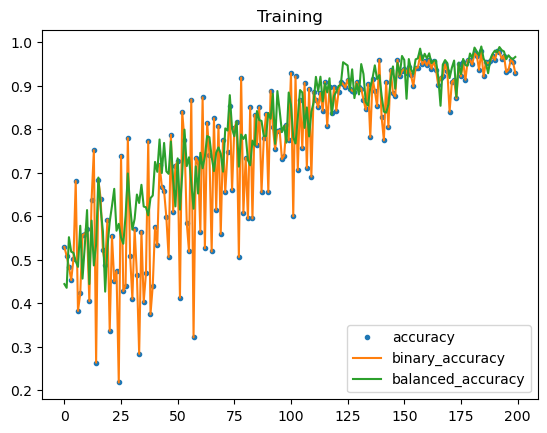

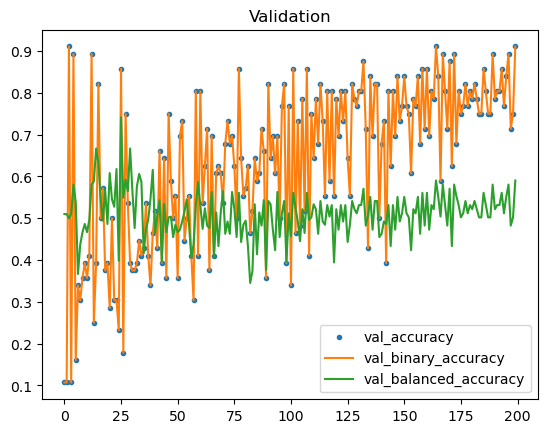

In [36]:
plt.plot(history_weighted.history['accuracy'], '.', label='accuracy')
plt.plot(history_weighted.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history_weighted.history['balanced_accuracy'], label='balanced_accuracy')
plt.legend();
plt.title('Training')
plt.show();

plt.figure()
plt.plot(history_weighted.history['val_accuracy'], '.', label='val_accuracy')
plt.plot(history_weighted.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.plot(history_weighted.history['val_balanced_accuracy'], label='val_balanced_accuracy')
plt.legend();
plt.title('Validation')
plt.show();

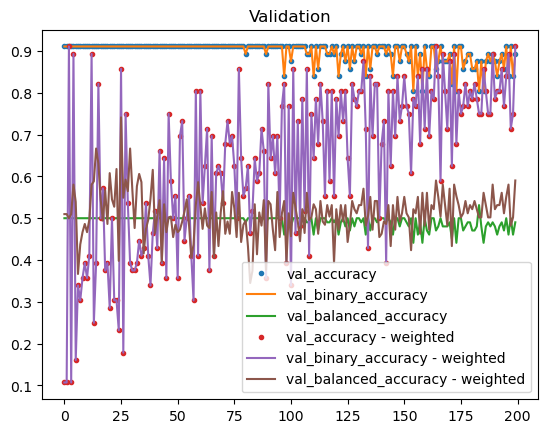

In [37]:
plt.figure()
plt.plot(history.history['val_accuracy'], '.', label='val_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.plot(history.history['val_balanced_accuracy'], label='val_balanced_accuracy')
plt.plot(history_weighted.history['val_accuracy'], '.', label='val_accuracy - weighted')
plt.plot(history_weighted.history['val_binary_accuracy'], label='val_binary_accuracy - weighted')
plt.plot(history_weighted.history['val_balanced_accuracy'], label='val_balanced_accuracy - weighted')
plt.legend();
plt.title('Validation')
plt.show();

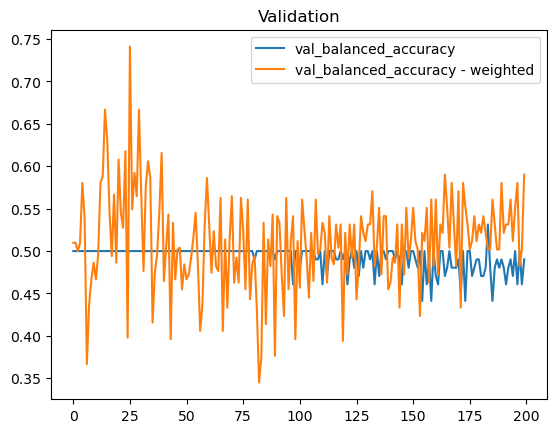

In [38]:
plt.figure()
plt.plot(history.history['val_balanced_accuracy'], label='val_balanced_accuracy')
plt.plot(history_weighted.history['val_balanced_accuracy'], label='val_balanced_accuracy - weighted')
plt.legend();
plt.title('Validation')
plt.show();